# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/workspace/circuit-finder")

# Load Dataset


In [3]:
import pickle
from circuit_finder.constants import ProjectDir
from circuit_finder.paper.run_leap_experiment_batched import LeapExperimentResult


def load_result(
    dataset_name: str, threshold: float, sweep_name: str
) -> LeapExperimentResult:
    save_dir = (
        ProjectDir
        / "results"
        / sweep_name
        / f"dataset={dataset_name}_threshold={threshold}"
    )

    with open(save_dir / "result.pkl", "rb") as file:
        result = pickle.load(file)

    return result

In [4]:
import pathlib
import pandas as pd
from circuit_finder.experiments.run_dataset_sweep import SELECTED_DATASETS
from circuit_finder.paper.run_leap_experiment_batched import THRESHOLDS

SWEEP_NAMES = [
    # batch size 1
    "corrupt_keep_error",
    "corrupt_ablate_error",
    "tokenwise_keep_error",
    "tokenwise_ablate_error",
    "c4_keep_error",
    "c4_ablate_error",
    "D_keep_error",
    "D_ablate_error",
    # batch size 8
    "clean_keep_error_bs8",
    "clean_ablate_error_bs8",
    "corrupt_keep_error_bs8",
    "corrupt_ablate_error_bs8",
    "tokenwise_keep_error_bs8",
    "tokenwise_ablate_error_bs8",
    "c4_keep_error_bs8",
    "c4_ablate_error_bs8",
    "D_keep_error_bs8",
    "D_ablate_error_bs8",
]


rows = []
for sweep_name in SWEEP_NAMES:
    for dataset_path in SELECTED_DATASETS:
        dataset_name = pathlib.Path(dataset_path).stem
        for threshold in THRESHOLDS:
            try:
                result = load_result(dataset_name, threshold, sweep_name)
            except FileNotFoundError:
                continue
            num_nodes = len(result.graph.get_src_nodes()) + len(
                result.error_graph.get_src_nodes()
            )
            rows.append(
                {
                    "sweep_name": sweep_name,
                    "dataset": dataset_name,
                    "threshold": threshold,
                    "num_nodes": num_nodes,
                    "clean_metric": result.clean_metric,
                    "graph_ablated_metric": result.graph_ablated_metric,
                    "fully_ablated_metric": result.fully_ablated_metric,
                }
            )

df = pd.DataFrame(rows)
df.head()

,sweep_name,dataset,threshold,num_nodes,clean_metric,graph_ablated_metric,fully_ablated_metric
0,corrupt_keep_error,docstring_prompts,0.003,2358,6.213511,7.482885,2.01716
1,corrupt_keep_error,docstring_prompts,0.006,1331,6.213511,6.916393,2.01716
2,corrupt_keep_error,docstring_prompts,0.010,878,6.213511,6.188367,2.01716
3,corrupt_keep_error,docstring_prompts,0.030,228,6.213511,3.594095,2.01716
4,corrupt_keep_error,docstring_prompts,0.060,103,6.213511,2.854639,2.01716


In [5]:
df

,sweep_name,dataset,threshold,num_nodes,clean_metric,graph_ablated_metric,fully_ablated_metric
0,corrupt_keep_error,docstring_prompts,0.003,2358,6.213511,7.482885,2.017160
1,corrupt_keep_error,docstring_prompts,0.006,1331,6.213511,6.916393,2.017160
2,corrupt_keep_error,docstring_prompts,0.010,878,6.213511,6.188367,2.017160
3,corrupt_keep_error,docstring_prompts,0.030,228,6.213511,3.594095,2.017160
4,corrupt_keep_error,docstring_prompts,0.060,103,6.213511,2.854639,2.017160
...,...,...,...,...,...,...,...
535,D_ablate_error_bs8,ioi_BABA_template_2_prompts,0.006,1006,4.051342,0.466116,0.492948
536,D_ablate_error_bs8,ioi_BABA_template_2_prompts,0.010,714,4.051342,0.464058,0.492948
537,D_ablate_error_bs8,ioi_BABA_template_2_prompts,0.030,281,4.051342,0.462356,0.492948
538,D_ablate_error_bs8,ioi_BABA_template_2_prompts,0.060,168,4.051342,0.467047,0.492948


# Faithfulness Curves

For each sweep and dataset, we want to plot faithfulness over many different settings. 

In [6]:
df["faithfulness"] = (df["graph_ablated_metric"] - df["fully_ablated_metric"]) / (
    df["clean_metric"] - df["fully_ablated_metric"]
)

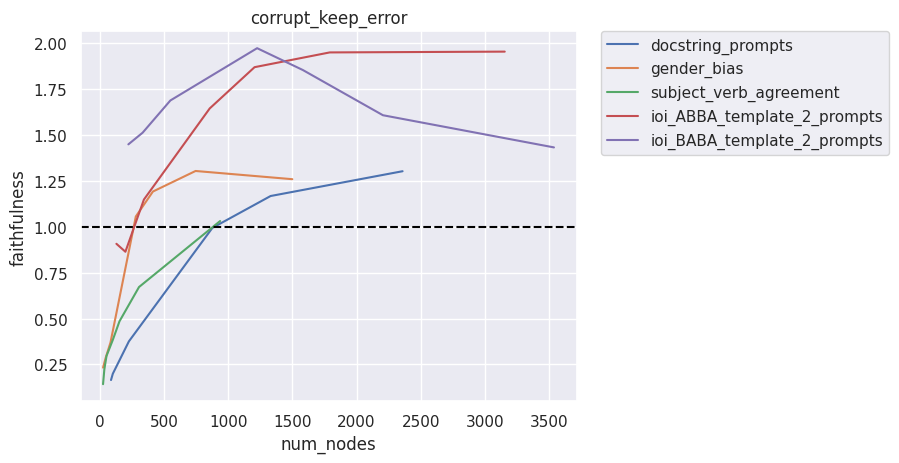

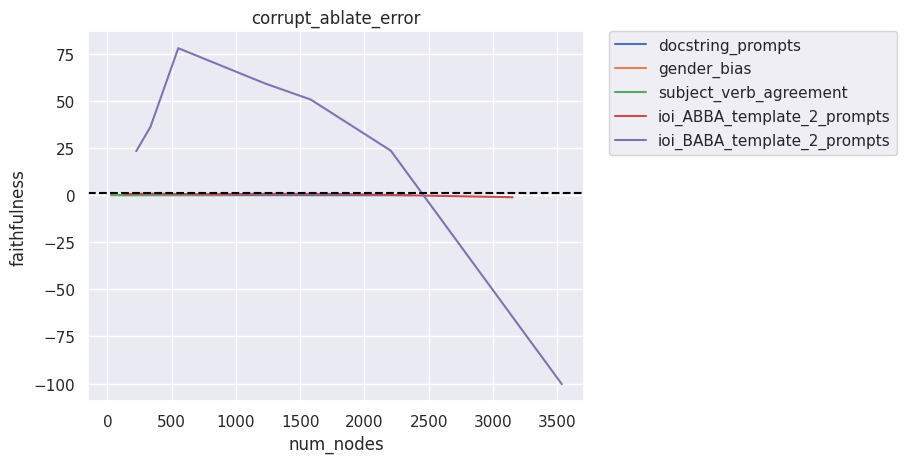

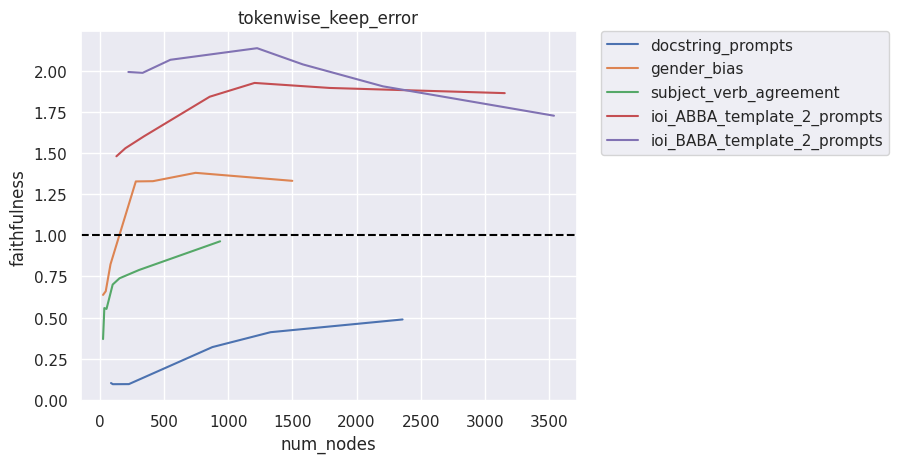

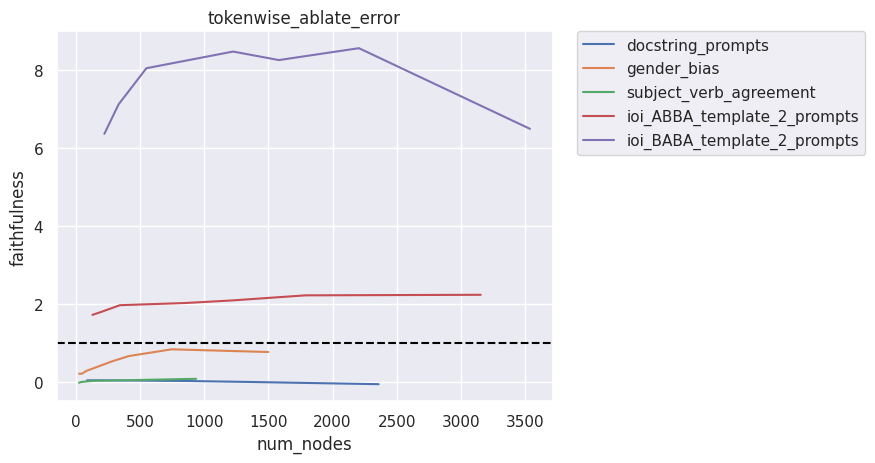

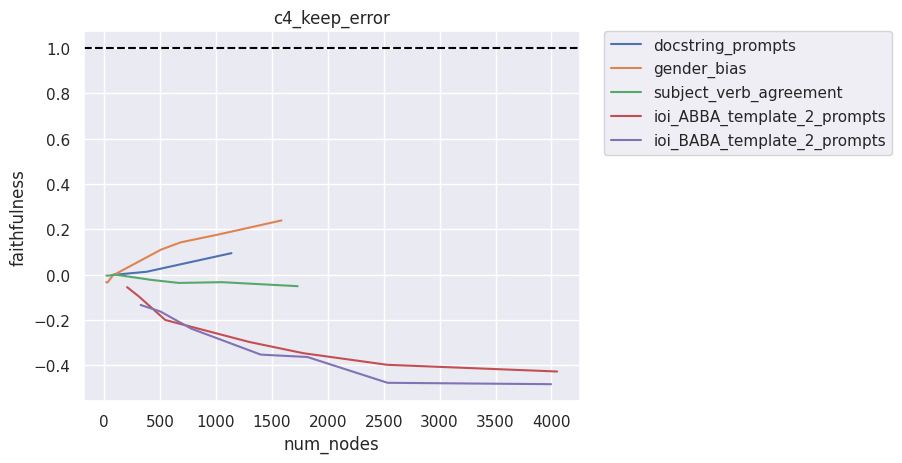

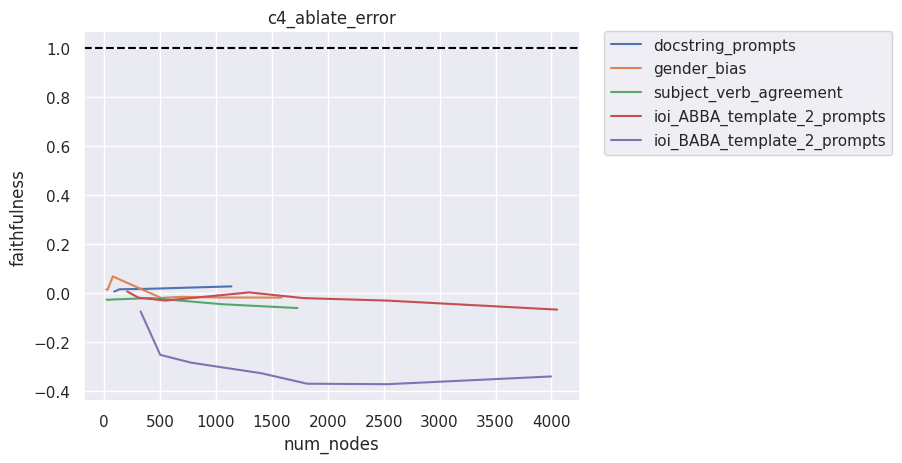

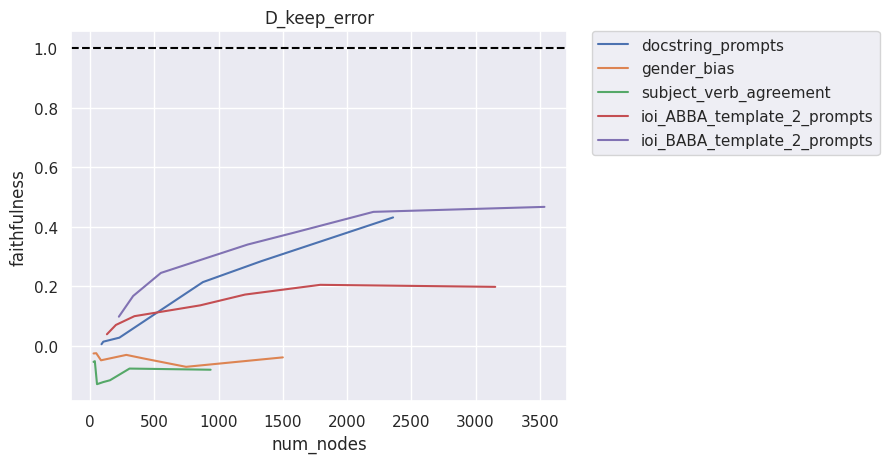

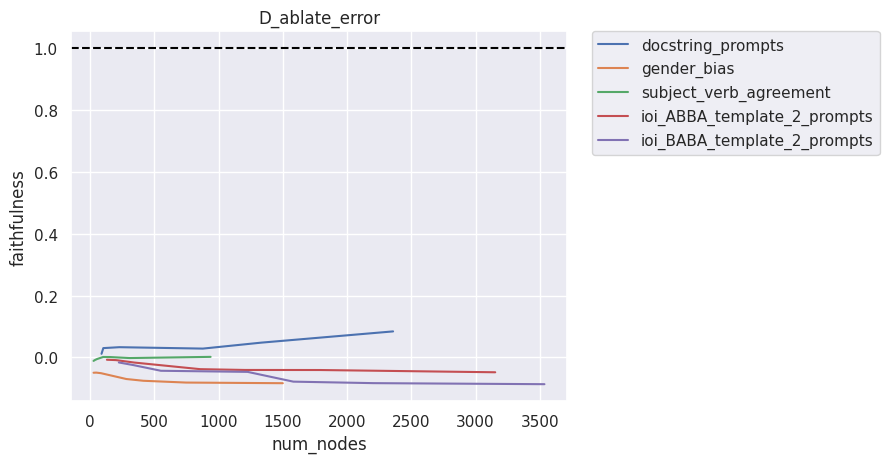

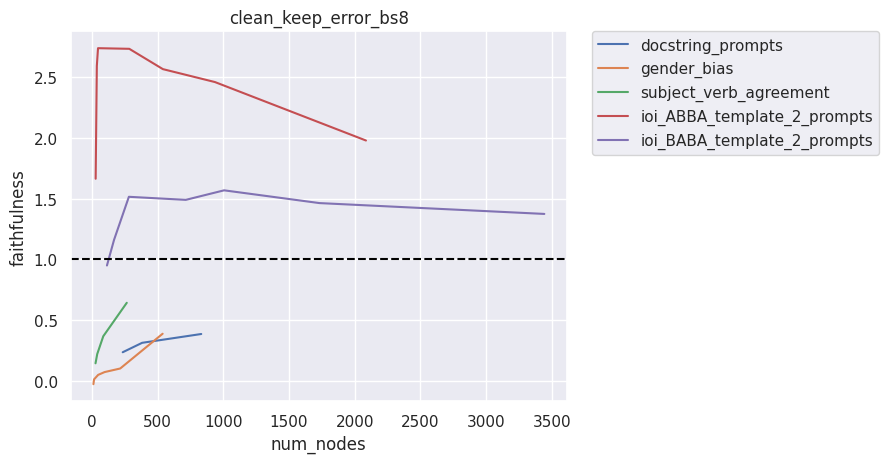

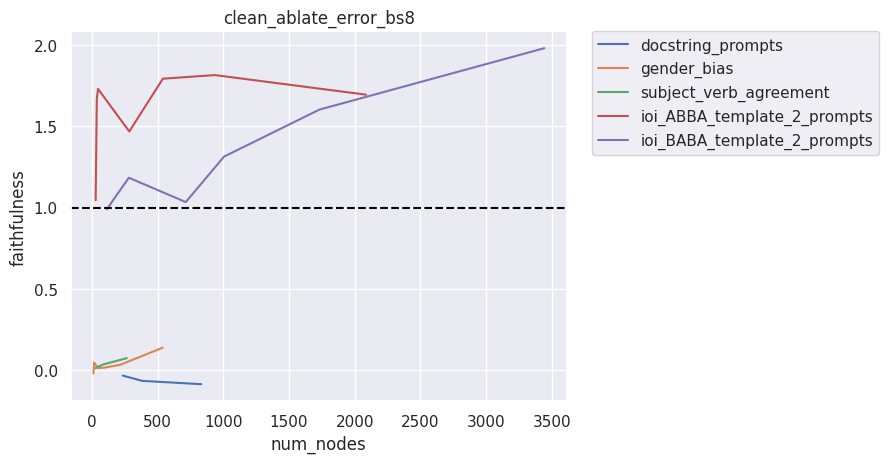

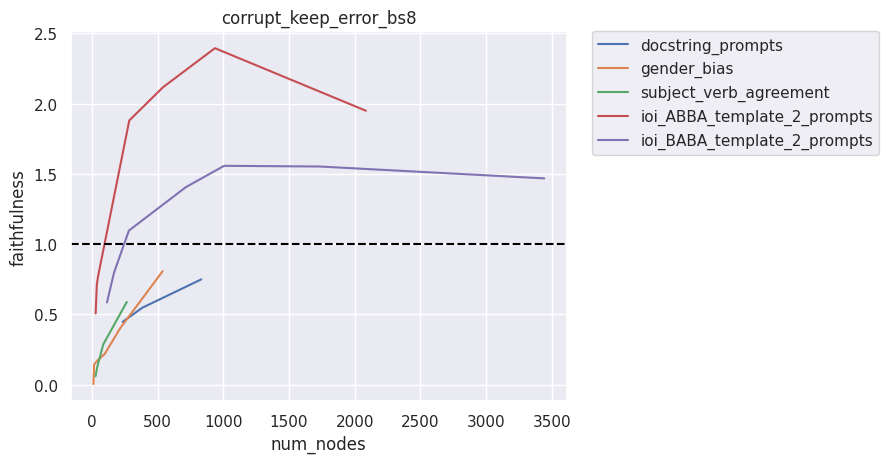

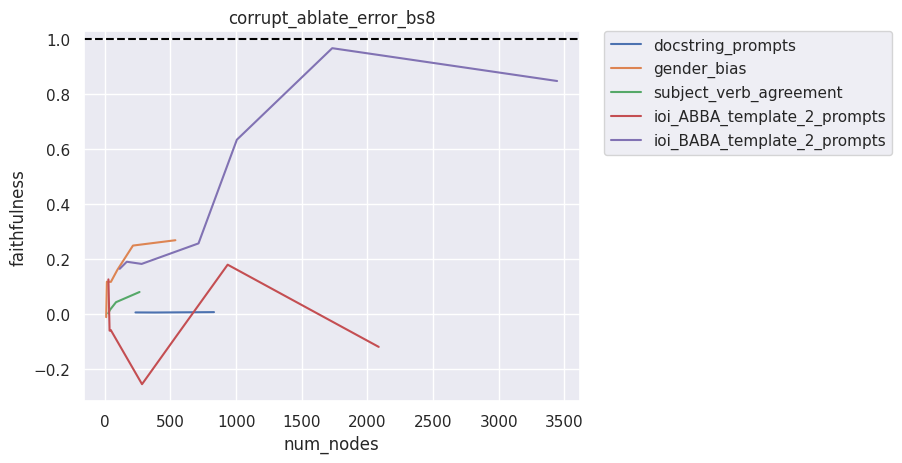

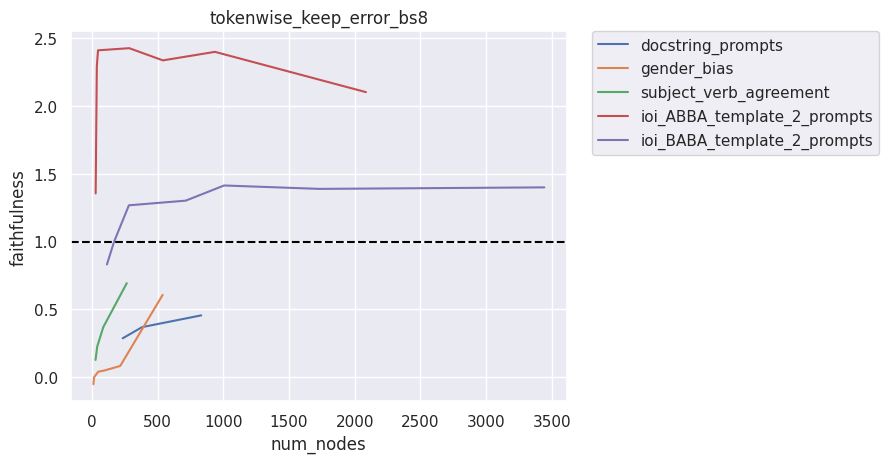

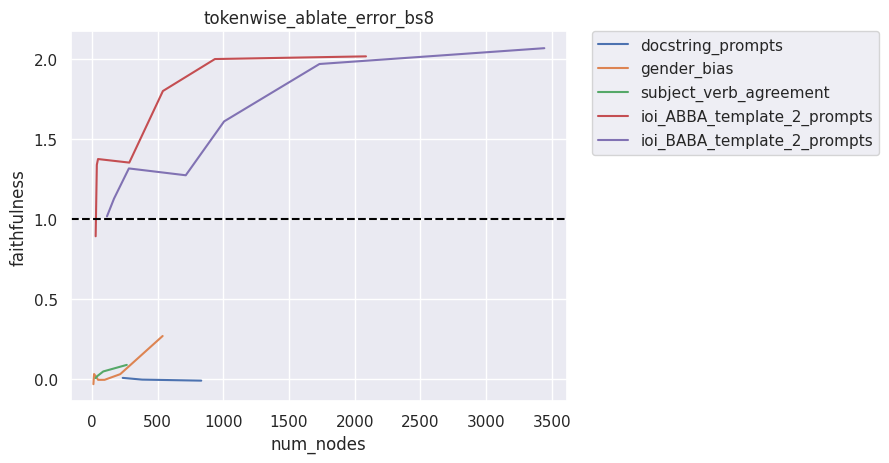

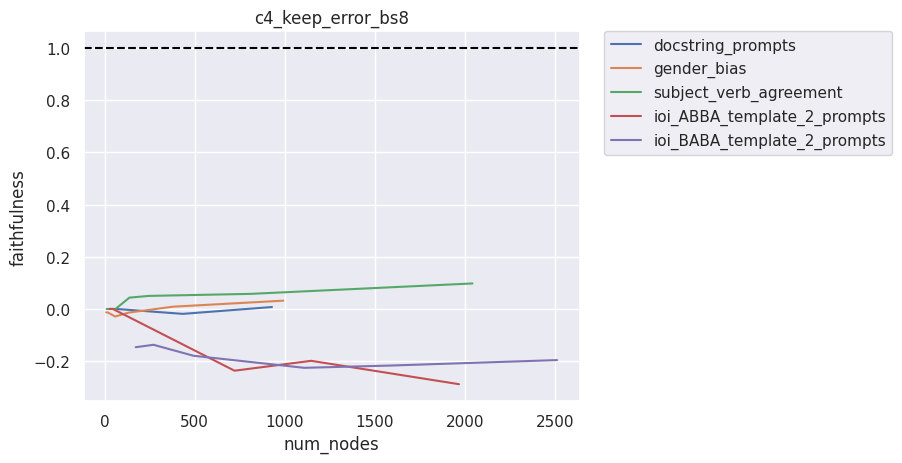

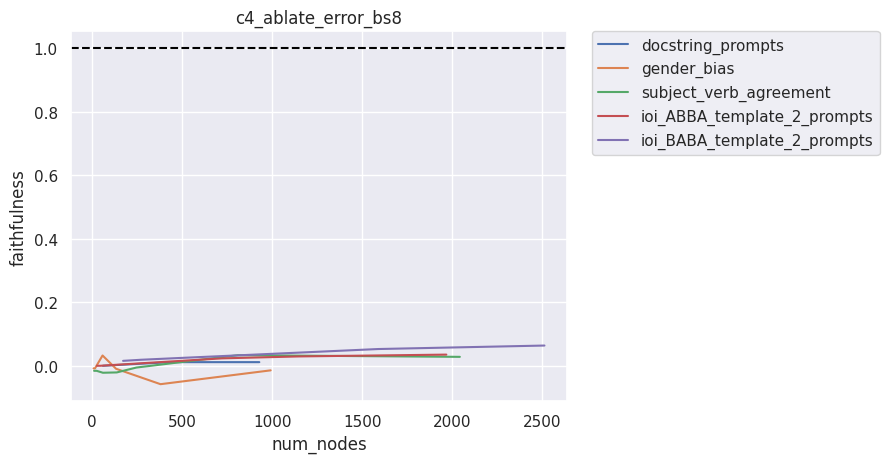

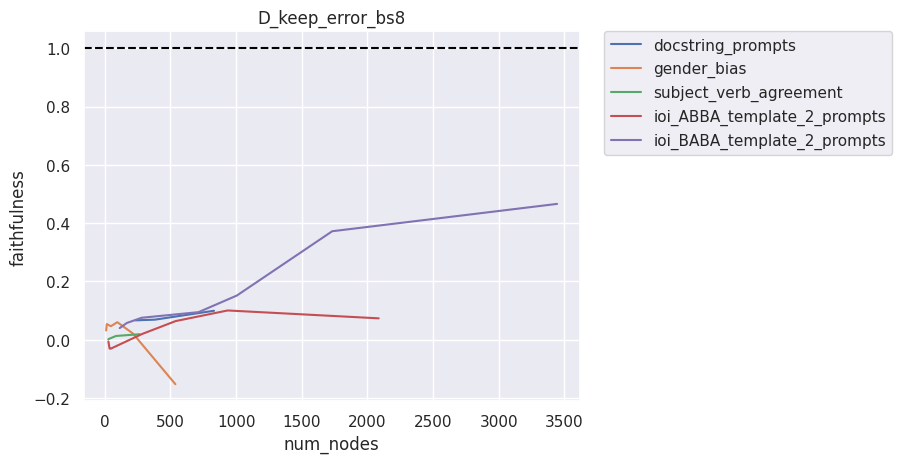

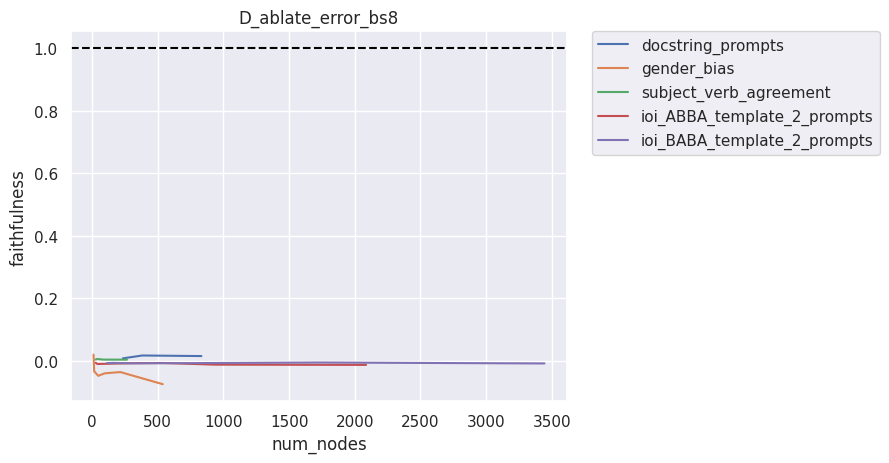

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

def make_plot_for_setting(df, sweep_name: str):
    fig, ax = plt.subplots()
    plot_df = df[(df.sweep_name == sweep_name)]
    sns.lineplot(data=plot_df, x="num_nodes", y="faithfulness", hue="dataset")
    ax.axhline(1, ls="--", color="black")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.title(sweep_name)

for sweep_name in SWEEP_NAMES:
    make_plot_for_setting(df, sweep_name)


# Noising & Denoising Curves

In [8]:
from circuit_finder.pretrained import load_model
from circuit_finder.pretrained import load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.indirect_leap import preprocess_attn_saes

model = load_model()
attn_sae_dict = load_attn_saes()
attn_sae_dict = preprocess_attn_saes(attn_sae_dict, model)
hooked_mlp_transcoder_dict = load_hooked_mlp_transcoders()

attn_saes = list(attn_sae_dict.values())
transcoders = list(hooked_mlp_transcoder_dict.values())

/workspace/circuit-finder/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [9]:
# Select a graph to load

import json 
from circuit_finder.metrics import batch_avg_answer_diff
from transformer_lens import utils

from circuit_finder.patching.ablate import (
    splice_model_with_saes_and_transcoders,
    filter_sae_acts_and_errors,
    get_ablation_result,
)

def get_ablation_results(result):
    graph = result.graph
    batch = result.batch

    clean_tokens = batch.clean
    corrupt_tokens = batch.corrupt

    nodes = [n for n in graph.get_src_nodes() if "metric" not in n]
    print(len(nodes))

    # Sanity-check the prompts
    clean_str = model.to_string(clean_tokens[:, 1:])[0]
    answer = model.to_string(batch.answers)[0]
    wrong_answer = model.to_string(batch.wrong_answers)[0]
    corrupt_str = model.to_string(corrupt_tokens[:, 1:])[0]

    # utils.test_prompt(clean_str, answer, model)
    # utils.test_prompt(corrupt_str, answer, model)
    # utils.test_prompt(corrupt_str, wrong_answer, model)

    def metric_fn(model, tokens):
        # Get the last-token logits
        logits = model(tokens)[:, -1, :]
        logit_diff = batch_avg_answer_diff(logits, batch)
        return logit_diff.mean()

    clean_metric = metric_fn(model, clean_tokens).item()
    corrupt_metric = metric_fn(model, corrupt_tokens).item()

    with splice_model_with_saes_and_transcoders(
        model, transcoders, attn_saes
    ) as spliced_model:
        _, clean_cache = model.run_with_cache(
            clean_tokens, names_filter=filter_sae_acts_and_errors
        )
        _, corrupt_cache = model.run_with_cache(
            corrupt_tokens, names_filter=filter_sae_acts_and_errors
        )

    noising_result = get_ablation_result(
        model,
        transcoders,
        attn_saes,
        clean_tokens=clean_tokens,
        corrupt_tokens=corrupt_tokens,
        clean_cache=clean_cache,
        corrupt_cache=corrupt_cache,
        nodes=nodes,
        metric_fn=metric_fn,
        setting="noising",
    )


    denoising_result = get_ablation_result(
        model,
        transcoders,
        attn_saes,
        clean_tokens=clean_tokens,
        corrupt_tokens=corrupt_tokens,
        clean_cache=clean_cache,
        corrupt_cache=corrupt_cache,
        nodes=nodes,
        metric_fn=metric_fn,
        setting="denoising",
    )

    results = {
        "clean_metric": clean_metric,
        "corrupt_metric": corrupt_metric,
        "noising": noising_result,
        "denoising": denoising_result,
        "n_nodes": len(nodes),
    }
    return results

In [11]:
from collections import defaultdict

all_results = defaultdict(dict)

selected_sweeps = ["corrupt_keep_error_bs8", "corrupt_ablate_error_bs8", "tokenwise_keep_error_bs8", "tokenwise_ablate_error_bs8"]
dataset_names = [
    "gender_bias",
    "subject_verb_agreement",
    "ioi_ABBA_template_3_prompts",
    "ioi_BABA_template_3_prompts",
    "docstring_prompts",
    # "greaterthan_gpt2-small_prompts"
]
for sweep_name in selected_sweeps:
    for dataset_name in dataset_names:
        for threshold in THRESHOLDS:
            try:
                exp_res = load_result(dataset_name, threshold, sweep_name)
                abl_res = get_ablation_results(exp_res)
                all_results[(sweep_name, dataset_name)][threshold] = abl_res
            except FileNotFoundError:
                pass

442
147
47
19
5
2
164
30
9
5
633
232
119
442
147
47
19
5
2
164
30
9
5
633
232
119
442
147
47
19
5
2
164
30
9
5
633
232
119
442
147
47
19
5
2
164
30
9
5
633
232
119


In [20]:
import pickle 
with open("all_ablation_results.pkl", "wb") as file:
    pickle.dump(all_results, file)

In [21]:
# Plot the results

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()


def make_plot(results, dataset_name, sweep_name):
    fig, ax = plt.subplots()
    n_results = len(results)
    alphas = np.linspace(1.0, 0.2, n_results)
    colors = sns.color_palette(n_colors=2)
    for i, (threshold, result) in enumerate(results.items()):
        n_nodes = result["n_nodes"]
        for j, setting in enumerate(["noising", "denoising"]):
            res = result[setting]
            coefficients = res.coefficient
            metrics = res.metric
            ax.plot(
                coefficients,
                metrics,
                label=f"{setting}_{n_nodes}",
                color=colors[j],
                alpha = alphas[i]
                # plot_kws=dict(alpha=alphas[i]),
            )
            ax.scatter(
                coefficients,
                metrics,
                color=colors[j],
                alpha = alphas[i]
                # plot_kws=dict(alpha=alphas[i]),
            )
        clean_metric = result["clean_metric"]
        corrupt_metric = result["corrupt_metric"]

    # Add text
    text_offset = -0.2
    ax.scatter([1], [clean_metric], color="green")
    ax.text(1, clean_metric + text_offset, "clean metric", fontsize=12)
    ax.scatter([0], [corrupt_metric], color="red")
    ax.text(0, corrupt_metric + text_offset, "corrupt metric", fontsize=12)

    ax.set_title(f"Ablation plot | dataset={dataset_name} | sweep={sweep_name}")
    ax.set_xlabel("Linear interpolation coefficient")
    ax.set_ylabel("Metric")
    # fig.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
    fig.show()
    fig.savefig(
        ProjectDir
        / "circuit_finder"
        / "paper"
        / "figures"
        / f"ablation_plot_{dataset_name}_{sweep_name}.png"
    )

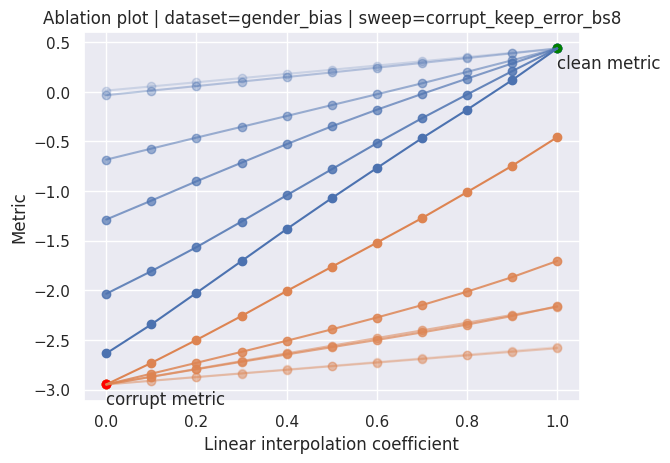

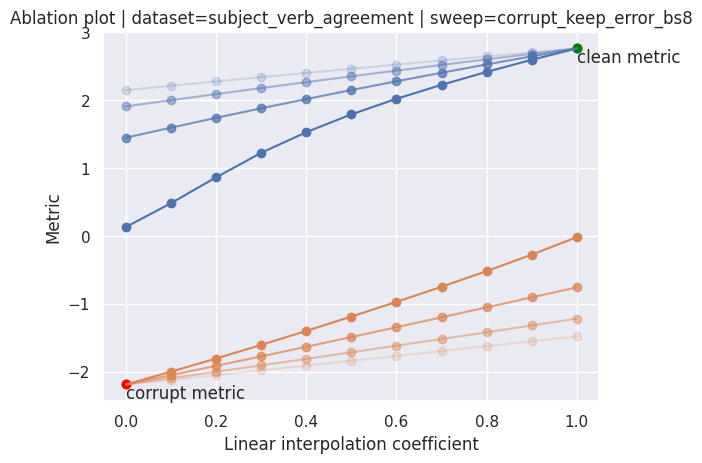

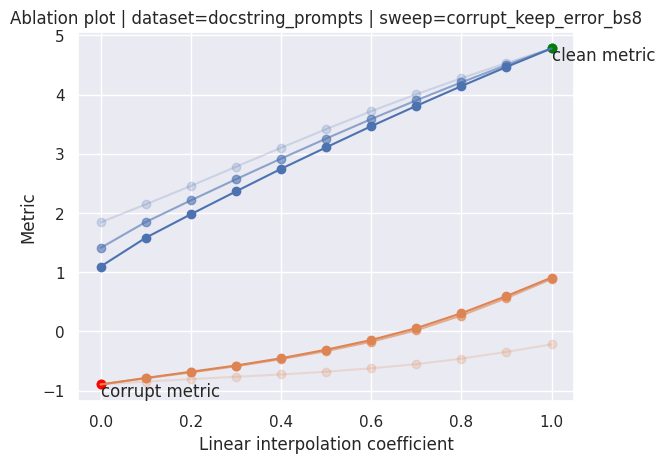

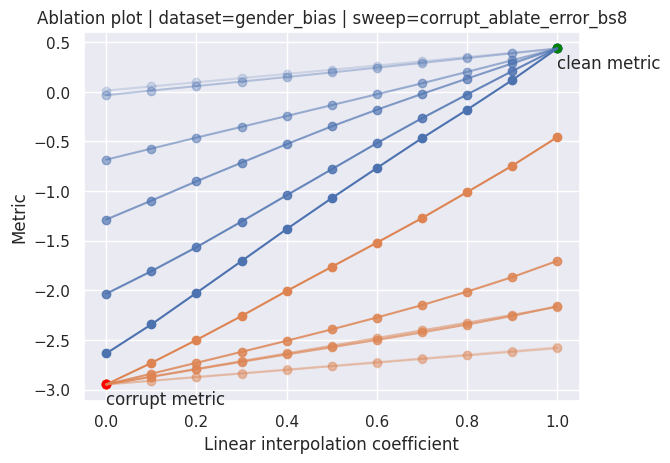

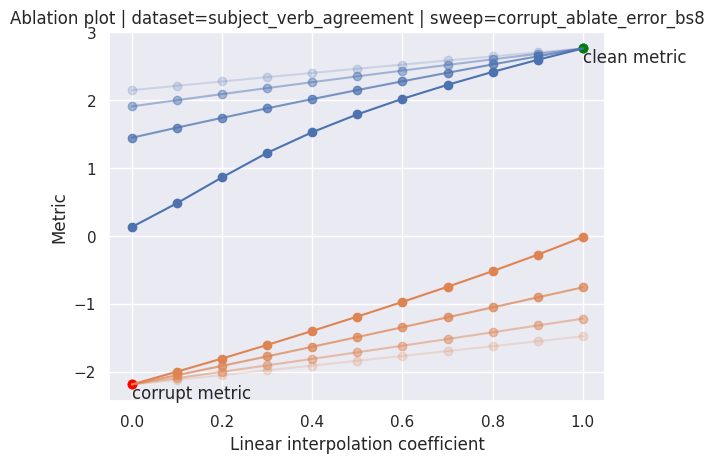

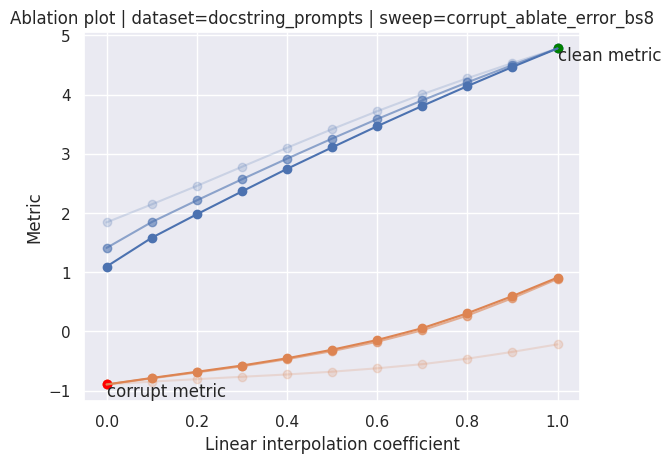

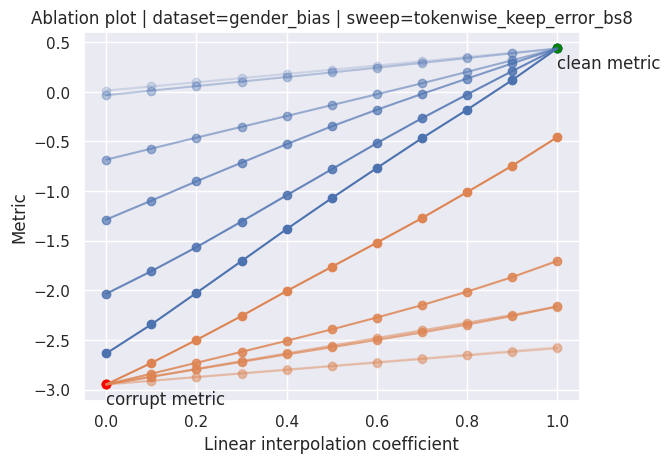

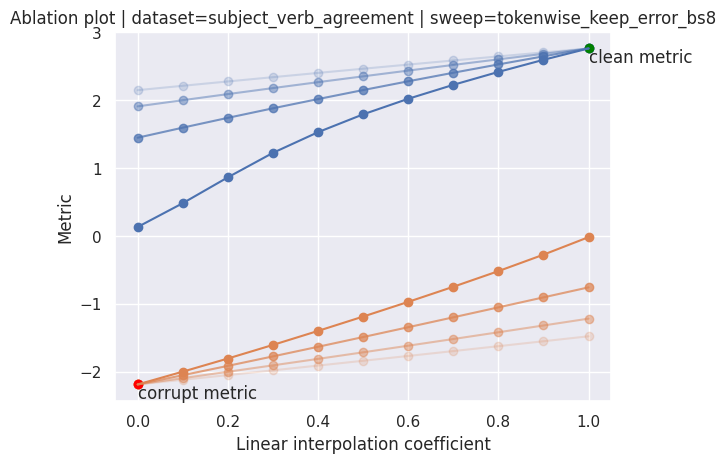

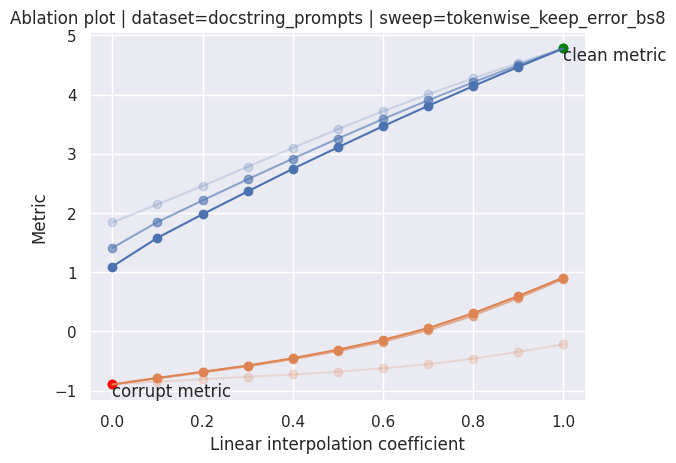

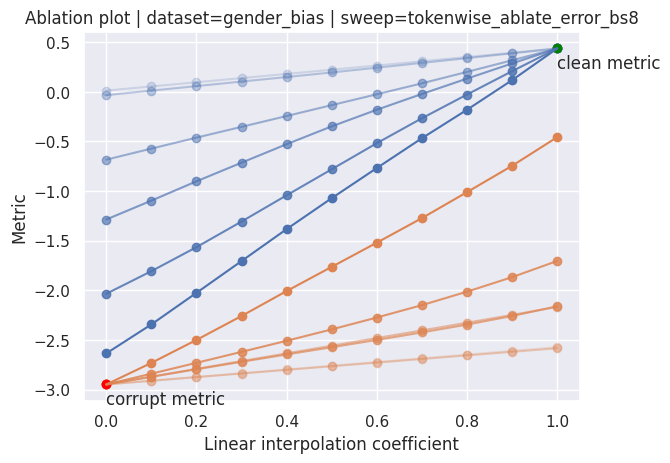

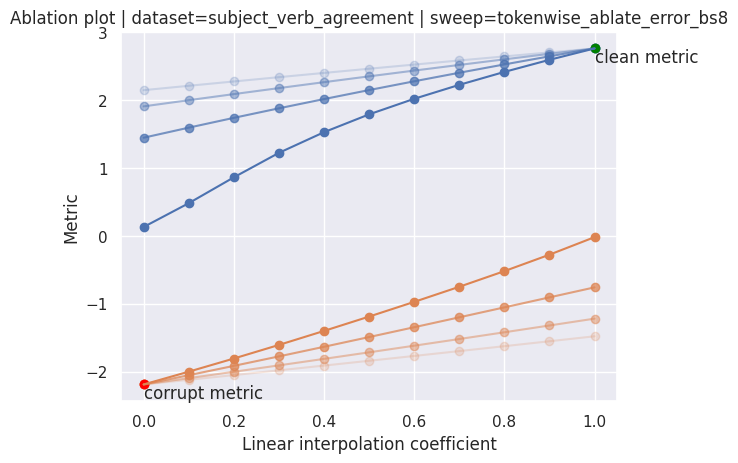

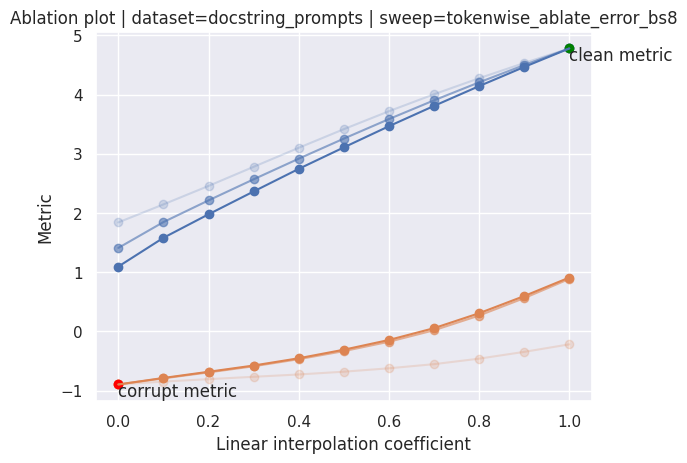

In [22]:
for (sweep_name, dataset_name), results in all_results.items():
    make_plot(results, dataset_name, sweep_name)

# New Faithfulness Curves

In [23]:
# Regenerate the faithfulness curves using the ablation results

import sys 
import pandas as pd
sys.path.append("/workspace/circuit-finder")
import pickle

with open("all_ablation_results.pkl", "rb") as file:
    all_results = pickle.load(file)

# Extract the data
rows = []

for (sweep_name, dataset_name), results in all_results.items():
    print(sweep_name, dataset_name)

    for threshold, result in results.items():
        clean_metric = result["clean_metric"]
        rows.append(
            {
                "sweep_name": sweep_name,
                "dataset": dataset_name,
                "threshold": threshold,
                "num_nodes": result["n_nodes"],
                "clean_metric": result["clean_metric"],
                "corrupt_metric": result["corrupt_metric"],
                "patch_metric": result["denoising"].metric[-1],
            }
        )

df = pd.DataFrame(rows)
df.head()



corrupt_keep_error_bs8 gender_bias
corrupt_keep_error_bs8 subject_verb_agreement
corrupt_keep_error_bs8 docstring_prompts
corrupt_ablate_error_bs8 gender_bias
corrupt_ablate_error_bs8 subject_verb_agreement
corrupt_ablate_error_bs8 docstring_prompts
tokenwise_keep_error_bs8 gender_bias
tokenwise_keep_error_bs8 subject_verb_agreement
tokenwise_keep_error_bs8 docstring_prompts
tokenwise_ablate_error_bs8 gender_bias
tokenwise_ablate_error_bs8 subject_verb_agreement
tokenwise_ablate_error_bs8 docstring_prompts


,sweep_name,dataset,threshold,num_nodes,clean_metric,corrupt_metric,patch_metric
0,corrupt_keep_error_bs8,gender_bias,0.001,442,0.437209,-2.947148,-0.456624
1,corrupt_keep_error_bs8,gender_bias,0.003,147,0.437209,-2.947148,-1.703467
2,corrupt_keep_error_bs8,gender_bias,0.006,47,0.437209,-2.947148,-2.159200
3,corrupt_keep_error_bs8,gender_bias,0.010,19,0.437209,-2.947148,-2.166306
4,corrupt_keep_error_bs8,gender_bias,0.030,5,0.437209,-2.947148,-2.582969


In [24]:
df[(df.dataset.str.contains('ioi'))]

,sweep_name,dataset,threshold,num_nodes,clean_metric,corrupt_metric,patch_metric


In [25]:
df["faithfulness"] = (df["patch_metric"] - df["corrupt_metric"]) / (df["clean_metric"] - df["corrupt_metric"]) 

Text(0.5, 1.0, 'Faithfulness curves for batch size 8 experiments')

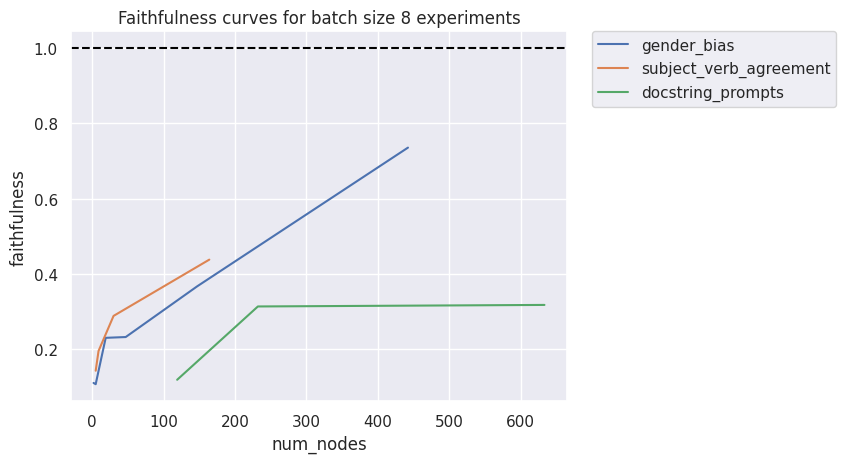

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = df[
    (df.sweep_name == 'corrupt_keep_error_bs8')
    & ~(df.dataset.str.contains('ioi'))
]

sns.set_theme()
sns.lineplot(data=plot_df, x="num_nodes", y="faithfulness", hue="dataset")
plt.axhline(1, ls="--", color="black")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Faithfulness curves for batch size 8 experiments")

/tmp/ipykernel_8700/3348896841.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


Text(0.5, 1.0, 'Faithfulness curves for batch size 1 experiments')

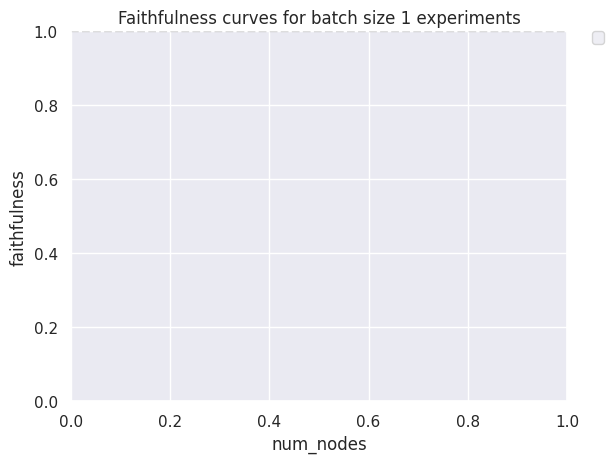

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = df[
    (df.sweep_name == "corrupt_keep_error") & ~(df.dataset.str.contains("ioi"))
]

sns.set_theme()
sns.lineplot(data=plot_df, x="num_nodes", y="faithfulness", hue="dataset")
plt.axhline(1, ls="--", color="black")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Faithfulness curves for batch size 1 experiments")